# Vessel Consumption Forecasting

This notebook contains code that analyses noon report data, which are sent- usually- every noon from the vessel to the shipping line. They contain data related to the time period they are related to, the vessels' route (location, speed), and some operating details, such as engine working hours, propeller total revolutions, and deadweight.

The notebook starts with the data exploration and cleaning phase, followed by the visualisation phase, and- ultimately- trains statistical and machine learning algorithms, for the aforementioned forecasting. 

## Importing Libraries and Reading data

In [702]:
import pandas as pd
import numpy as np
import seaborn as sns
data = pd.read_csv('data_set_20210520_v_0_01.csv', parse_dates=['Date_Start','Date_End'])

The data are not ideal for the development of complex forecasting models, due to their- relatively- small dimensions. However, they are adequate for the showcase of how similar applications are developed.

In [703]:
data.head()

,Vessel_Name,Date_Start,Date_End,Vessel_Position_Latitude,Vessel_Position_Longitude,Vessel_Speed,Deadweigth_tonage,Main_Engine_Total_Revolution,Main_Engine_Working_Hours,Main_Engine_Total_Consumption
0,Vessel_1,2019-08-02 03:00:00,2019-08-03 02:00:00,36.813800,135.224816,0.0000,23767.956,NaN,NaN,NaN
1,Vessel_1,2019-08-03 02:00:00,2019-08-04 09:12:00,36.525833,134.891334,NaN,23767.956,34304.000,10.0104,8.0446
2,Vessel_1,2019-08-04 09:12:00,2019-08-05 07:30:00,37.488667,138.743334,3.1598,35448.732,76297.456,23.0136,18.9544
3,Vessel_1,2019-08-05 07:30:00,2019-08-06 03:00:00,37.630000,138.886000,NaN,35448.732,5664.448,1.7544,1.2122
4,Vessel_1,2019-08-06 03:00:00,2019-08-07 03:00:00,37.612333,138.850334,NaN,35448.732,4263.344,1.4448,0.7714


## Data Exploration and Cleaning

### Handling Fluctuating Hour Intervals
It seems that the time period between the start and end dates (thus, the analysis period) varies. Typically, the time period should be one day (24 hours), but, as is evident below, this is not necessarily the case.
In order to analyse the data, independetly of those time period fluctuations, a calculated column will be introduced, which will contain the *hour interval* between the start and end dates.

In [704]:
hour_Interval = (data.Date_End-data.Date_Start).astype('timedelta64[m]')/60
data.insert(3, "Hour_Interval", hour_Interval)
data.head()

,Vessel_Name,Date_Start,Date_End,Hour_Interval,Vessel_Position_Latitude,Vessel_Position_Longitude,Vessel_Speed,Deadweigth_tonage,Main_Engine_Total_Revolution,Main_Engine_Working_Hours,Main_Engine_Total_Consumption
0,Vessel_1,2019-08-02 03:00:00,2019-08-03 02:00:00,23.0,36.813800,135.224816,0.0000,23767.956,NaN,NaN,NaN
1,Vessel_1,2019-08-03 02:00:00,2019-08-04 09:12:00,31.2,36.525833,134.891334,NaN,23767.956,34304.000,10.0104,8.0446
2,Vessel_1,2019-08-04 09:12:00,2019-08-05 07:30:00,22.3,37.488667,138.743334,3.1598,35448.732,76297.456,23.0136,18.9544
3,Vessel_1,2019-08-05 07:30:00,2019-08-06 03:00:00,19.5,37.630000,138.886000,NaN,35448.732,5664.448,1.7544,1.2122
4,Vessel_1,2019-08-06 03:00:00,2019-08-07 03:00:00,24.0,37.612333,138.850334,NaN,35448.732,4263.344,1.4448,0.7714


23.0    1255
25.0    1192
1.0      534
1.5      440
2.0      401
Name: Hour_Interval, dtype: int64

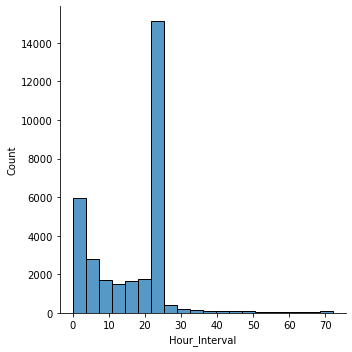

In [705]:
sns.displot(x='Hour_Interval', data=data, bins=20)
data.loc[data.Hour_Interval != 24, ['Hour_Interval']].Hour_Interval.value_counts().iloc[0:5]

After the first step of the calculation (the hour interval), we need to remove the time dimension from the measures that are influenced by it, accordingly.

In [706]:
data_hourly = data.iloc[:, 0:8]
data_hourly.head()

,Vessel_Name,Date_Start,Date_End,Hour_Interval,Vessel_Position_Latitude,Vessel_Position_Longitude,Vessel_Speed,Deadweigth_tonage
0,Vessel_1,2019-08-02 03:00:00,2019-08-03 02:00:00,23.0,36.813800,135.224816,0.0000,23767.956
1,Vessel_1,2019-08-03 02:00:00,2019-08-04 09:12:00,31.2,36.525833,134.891334,NaN,23767.956
2,Vessel_1,2019-08-04 09:12:00,2019-08-05 07:30:00,22.3,37.488667,138.743334,3.1598,35448.732
3,Vessel_1,2019-08-05 07:30:00,2019-08-06 03:00:00,19.5,37.630000,138.886000,NaN,35448.732
4,Vessel_1,2019-08-06 03:00:00,2019-08-07 03:00:00,24.0,37.612333,138.850334,NaN,35448.732


In [707]:
revsPerHour = data.Main_Engine_Total_Revolution/data.Hour_Interval
data_hourly.insert(8, "Revs_Per_Hour", revsPerHour)

engHrsPerHour = data.Main_Engine_Working_Hours/data.Hour_Interval
data_hourly.insert(9, "Eng_Hrs_Per_Hour", engHrsPerHour)

consPerHour = data.Main_Engine_Total_Consumption/data.Hour_Interval
data_hourly.insert(10, "Cons_Per_Hour", consPerHour)

data_hourly.head()

,Vessel_Name,Date_Start,Date_End,Hour_Interval,Vessel_Position_Latitude,Vessel_Position_Longitude,Vessel_Speed,Deadweigth_tonage,Revs_Per_Hour,Eng_Hrs_Per_Hour,Cons_Per_Hour
0,Vessel_1,2019-08-02 03:00:00,2019-08-03 02:00:00,23.0,36.813800,135.224816,0.0000,23767.956,NaN,NaN,NaN
1,Vessel_1,2019-08-03 02:00:00,2019-08-04 09:12:00,31.2,36.525833,134.891334,NaN,23767.956,1099.487179,0.320846,0.257840
2,Vessel_1,2019-08-04 09:12:00,2019-08-05 07:30:00,22.3,37.488667,138.743334,3.1598,35448.732,3421.410583,1.032000,0.849973
3,Vessel_1,2019-08-05 07:30:00,2019-08-06 03:00:00,19.5,37.630000,138.886000,NaN,35448.732,290.484513,0.089969,0.062164
4,Vessel_1,2019-08-06 03:00:00,2019-08-07 03:00:00,24.0,37.612333,138.850334,NaN,35448.732,177.639333,0.060200,0.032142


### Getting a sense of the Data

Estimating what percentage of the data can be used for the models' training.

In [708]:
data_len = len(data_hourly)
nan_cons = data_hourly.Cons_Per_Hour.isnull().value_counts().loc[True]
print(f'The dataset contains {format(data_len, ",")} total engine consumption values, out of which {format(nan_cons, ",")} ({format(nan_cons/data_len*100, ".1f")}%)' +
        ' are Nan (missing/null).')

The dataset contains 31,951 total engine consumption values, out of which 10,007 (31.3%) are Nan (missing/null).


It seems that the studied vessels are only 68, which will reduce the predicting (and generalising) capabilities of the following models, possibly due to overfitting the small dataset.

In [709]:
tot_dis = format((data.Vessel_Speed*data.Hour_Interval).sum(), ',.0f')
print(f'The dataset contains {data.Vessel_Name.unique().size} vessels, covering a total distance of {tot_dis} miles.')
tot_hrs = format(data.Hour_Interval.sum(), ',.0f')
print(f'A total of {tot_hrs} voyage hours were studied.')

The dataset contains 68 vessels, covering a total distance of 2,877,391 miles.
A total of 543,280 voyage hours were studied.


By looking for outliers in the consumption data, it is apparent that they contain a value that is most probably erroneous; thus, we remove it. Consecutively, by the process of removing the outlier value, the Nan values from the consumption data are eliminated, which also eliminates all the records that had zero vessel speed (which logically had zero consumption).

8319     192.023500
14119      5.142667
14116      5.069200
14104      5.004917
14117      5.004917
Name: Cons_Per_Hour, dtype: float64


,Vessel_Name,Date_Start,Date_End,Hour_Interval,Vessel_Position_Latitude,Vessel_Position_Longitude,Vessel_Speed,Deadweigth_tonage,Revs_Per_Hour,Eng_Hrs_Per_Hour,Cons_Per_Hour
8319,Vessel_24,2019-04-16 04:00:00,2019-04-17 04:00:00,24.0,27.719,129.755334,10.82018,163829.7522,4849.906667,1.032,192.0235


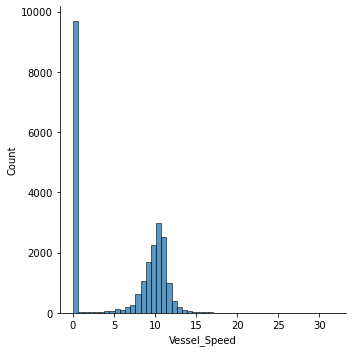

In [710]:
print(data_hourly.loc[:, 'Cons_Per_Hour'].nlargest(5))
sns.displot(data_hourly.Vessel_Speed, bins=50)
data_hourly.loc[data_hourly.Cons_Per_Hour == data_hourly.Cons_Per_Hour.nlargest(1).values[0]]

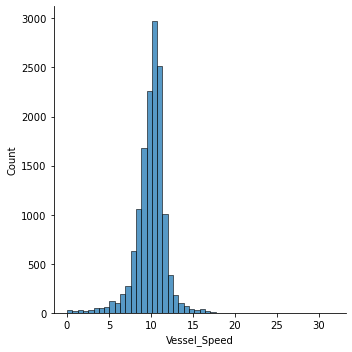

In [711]:
# Removing Outlier
data_hourly = data_hourly.loc[data_hourly.Cons_Per_Hour < data_hourly.Cons_Per_Hour.nlargest(1).values[0]]

sns.displot(data_hourly.Vessel_Speed, bins=50)

The rest of the numerical values that will be studied seem fine.

In [712]:
print(data_hourly.loc[:, 'Vessel_Speed'].nlargest(5))
print(data_hourly.loc[:, 'Deadweigth_tonage'].nlargest(5))
print(data_hourly.loc[:, 'Revs_Per_Hour'].nlargest(5))
print(data_hourly.loc[:, 'Eng_Hrs_Per_Hour'].nlargest(5))

26970    31.5980
29925    29.0360
27130    20.4106
25124    20.3252
26338    18.9588
Name: Vessel_Speed, dtype: float64
14169    301771.188
14170    301771.188
14171    301771.188
14172    301771.188
14173    301771.188
Name: Deadweigth_tonage, dtype: float64
11334    8503.104000
11321    8327.296000
9097     7842.439333
9617     7739.840000
27130    7697.496000
Name: Revs_Per_Hour, dtype: float64
26531    1.121739
13906    1.033853
16316    1.032938
16181    1.032788
249      1.032000
Name: Eng_Hrs_Per_Hour, dtype: float64


The connection between the various other features and the fuel consumption can be thoroughly studied,for example through the use of distribution plots, like the ones below. Indicatively, we can see the connection between the engine's working hours and the total consumption.<br><br>
Some conclusions that we can deduct from the plots:
1. The idling vessels have low consumption
2. Most of the data lies in the upper end of working hours, approximately 1, and then the connection between the variables becomes more obscure, linking to the fact that there are many other variables that affect the total consumption
3. The total engine working hours, per hour, sometimes surpass 1, which can be attributed to inaccurate data

In [ ]:
sns.displot(data=data_hourly, x="Eng_Hrs_Per_Hour", y="Cons_Per_Hour", kind="kde", rug=True)

Since the visualization possibilities are numerous, some additional visualizations were chosen to be provided below. Similarly, the plots below help us reach some conclusions:
1. Most of the consumption reaches 2, with a lot of values being close to zero, possibly alluding to the fact that the vessels stay idle for long periods of time, when not travelling
2. The deadweight seems to vary, while some vetrical columns can be seen. This is probably the vessel types, with the differing deadweights, like the type of vessel that has a deadweight between 250,000 and 300,000 tonnes
3. The consumption seems to increase linearly, while the engine working hours increase, until it reaches 1, which is where the most values are found.

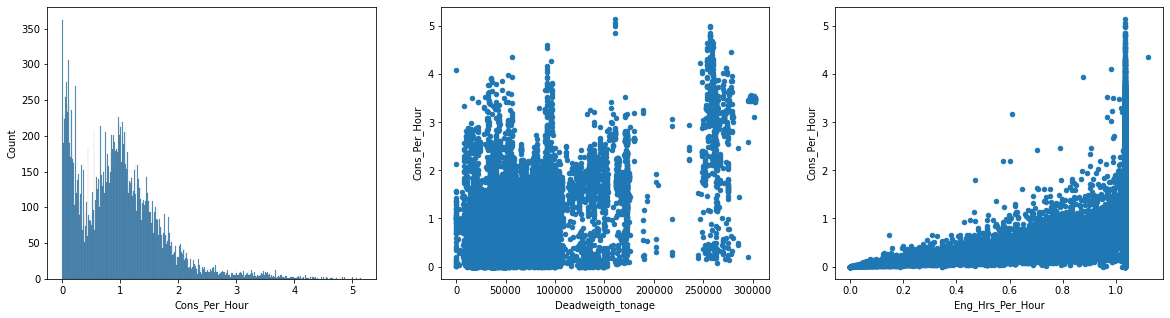

In [714]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(131)
sns.histplot(data_hourly.Cons_Per_Hour, bins=400)

ax2 = fig.add_subplot(132)
data_hourly.plot.scatter(x="Deadweigth_tonage", y="Cons_Per_Hour", ax=ax2)

ax3 = fig.add_subplot(133)
data_hourly.plot.scatter(x="Eng_Hrs_Per_Hour", y="Cons_Per_Hour", ax=ax3)
plt.show()

Furthermore, getting into slightly more complex visualizations, plotting the locations from which the noon reports originated seems very helpful and fun. The map visualization below, from plotly, is interactive, allowing the user to control what he/she sees and the respective details.

In [715]:
import plotly.express as px

fig = px.scatter_geo(data, lat='Vessel_Position_Latitude',lon='Vessel_Position_Longitude', hover_name="Vessel_Name")
fig.update_layout(title = 'Vessel Positions', title_x=0.5)
fig.update_traces(marker_size=0.5, opacity = 0.7)
fig.show()

### Feature Correlations
It seems that the correlation between the engine revolutions and the working hours is borderline high. However, it will be kept as a feature, since the number of features is limited and every added explained variance is welcome.

<AxesSubplot:>

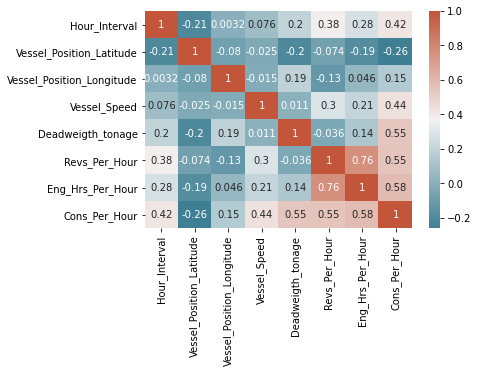

In [716]:
corr = data_hourly.corr() 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### Hemisphere Comparison
Another interesting analytical possibility, is the comparison of the voyages between the southern and the northern hemisphere.

In [717]:
s_hemi_mean = data_hourly.loc[data.Vessel_Position_Latitude < 0].describe().iloc[1]
n_hemi_mean = data_hourly.loc[data.Vessel_Position_Latitude > 0].describe().iloc[1]

hemis_means = pd.concat([s_hemi_mean, n_hemi_mean], axis=1, keys=['Southern Hemisphere','Northern Hemisphere'])

There are some discrepances between the two hemispheres, for certain columns and their respective values. More specifically, it is quite apparent in the deadweights and hourly consumption, which were proven to be correlated above.<br>A possible justification lies in the nature of the routes in the southern hemisphere, which are mostly long-haul; in comparison with the northern one, where many short-haul routes are operated (for example, by looking at the map above, in the Mediterranean).

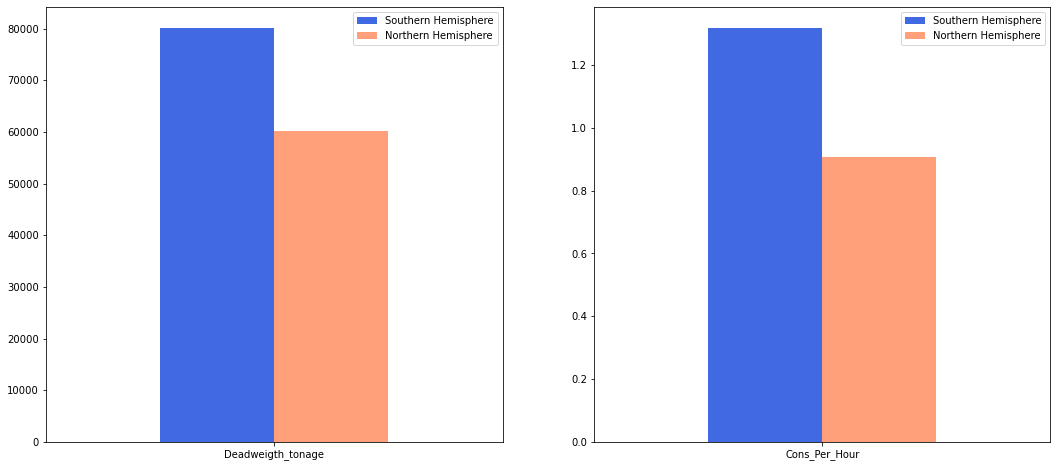

,Southern Hemisphere,Northern Hemisphere
Hour_Interval,20.141373,14.969463
Vessel_Position_Latitude,-23.354094,32.755800
Vessel_Position_Longitude,24.007531,21.740316
Vessel_Speed,9.894590,9.975754
Deadweigth_tonage,80166.152170,60137.725613
Revs_Per_Hour,4121.223577,3677.001370
Eng_Hrs_Per_Hour,0.976354,0.852065
Cons_Per_Hour,1.318211,0.906749


In [718]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
hemis_means.loc[['Deadweigth_tonage'], :].plot(ax=ax,kind='bar',color={'Southern Hemisphere': 'royalblue', 'Northern Hemisphere': 'lightsalmon'}, rot=0)
ax = fig.add_subplot(122)
hemis_means.loc[['Cons_Per_Hour'], :].plot(kind='bar',ax=ax,color={'Southern Hemisphere': 'royalblue', 'Northern Hemisphere': 'lightsalmon'}, rot=0)
plt.show()

hemis_means

The vessel speed seems to revolve around 10, with small deviations. The consumption per hour mostly revolves around one, but there are a lot of values close to zero. The data concerning those seems to be related to idle vessels, so the data concerning zero consumption are removed, since the point of the following analysis is to forecast consumption of a moving vessel.

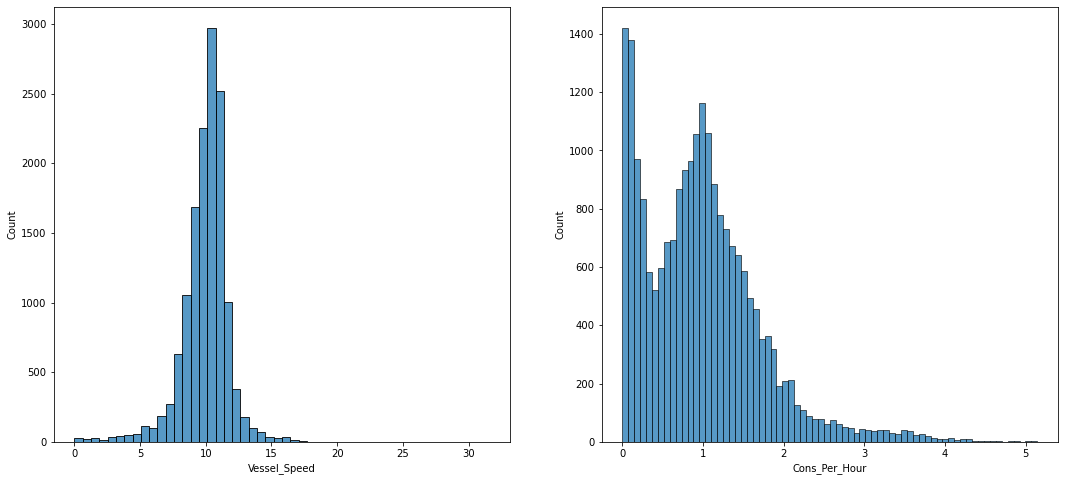

,Hour_Interval,Vessel_Position_Latitude,Vessel_Position_Longitude,Vessel_Speed,Deadweigth_tonage,Revs_Per_Hour,Eng_Hrs_Per_Hour,Cons_Per_Hour
count,239.000000,239.000000,239.000000,2.0,239.000000,239.0,239.000000,239.0
mean,14.076430,30.483767,16.879869,0.0,52424.989961,0.0,0.072385,0.0
std,12.415582,18.627422,54.899654,0.0,35962.597899,0.0,0.258359,0.0
min,0.100000,-41.089133,-109.325466,0.0,10790.694000,0.0,0.000000,0.0
25%,3.500000,25.346366,2.031216,0.0,28544.157000,0.0,0.000000,0.0
50%,12.500000,38.135267,27.374166,0.0,38816.352000,0.0,0.000000,0.0
75%,24.000000,43.619000,40.247159,0.0,65551.248000,0.0,0.000000,0.0
max,72.000000,63.617667,154.977016,0.0,149909.270400,0.0,1.032000,0.0


In [719]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
sns.histplot(data_hourly.Vessel_Speed, ax=ax, bins=50)
ax2 = fig.add_subplot(122)
sns.histplot(x=data_hourly.Cons_Per_Hour, ax=ax2, bins=70)
plt.show()
data_hourly.loc[data_hourly.Cons_Per_Hour==0].describe()

Removing data with zero consumption.

In [720]:
data_hourly = data_hourly.loc[data_hourly.Cons_Per_Hour > 0]

Further data exploration shows that Nan values remain in the vessel speed column.

In [721]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%45s %20s   %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%45s %20s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))

initial_eda(data_hourly)

Dimensions : 21704 rows, 11 columns
Total NA Values : 7758 
                                  Column Name            Data Type    #Distinct  NA Values
                                  Vessel_Name               object           68          0
                                   Date_Start       datetime64[ns]        11161          0
                                     Date_End       datetime64[ns]        11479          0
                                Hour_Interval              float64          572          0
                     Vessel_Position_Latitude              float64         7878          0
                    Vessel_Position_Longitude              float64        11120          0
                                 Vessel_Speed              float64          968       7758
                            Deadweigth_tonage              float64         4427          0
                                Revs_Per_Hour              float64        19455          0
                             E

# Weather API
The existing dataset can easily be anhanced by the use of a Weather API. Since the consumption is greatly affected by the weather, such data are essential in the accuracy of the forecast. There are multiple Weather APIs, but for the specific application of historic marine weather data, for thousands of records (API calls), only paid alternatives exist. Thus, the below code is presented as an example of a possible data enhancement method.

In [722]:
import requests
import json

url = "http://api.worldweatheronline.com/premium/v1/past-marine.ashx"
lanlon = str(data.iloc[10,4])+","+str(data.iloc[10,5])
querystring = {"key":"66fca0bbc2dd41a7815204317210107","format":"json","q":lanlon,"date":"2021-06-18"}

response = requests.request("GET", url, params=querystring)
json = json.loads(response.text)

In [723]:
json['data']['weather'][0]['hourly'][0].keys()

dict_keys(['time', 'tempC', 'tempF', 'windspeedMiles', 'windspeedKmph', 'winddirDegree', 'winddir16Point', 'weatherCode', 'weatherIconUrl', 'weatherDesc', 'precipMM', 'precipInches', 'humidity', 'visibility', 'visibilityMiles', 'pressure', 'pressureInches', 'cloudcover', 'HeatIndexC', 'HeatIndexF', 'DewPointC', 'DewPointF', 'WindChillC', 'WindChillF', 'WindGustMiles', 'WindGustKmph', 'FeelsLikeC', 'FeelsLikeF', 'sigHeight_m', 'swellHeight_m', 'swellHeight_ft', 'swellDir', 'swellDir16Point', 'swellPeriod_secs', 'waterTemp_C', 'waterTemp_F', 'uvIndex'])

# Consumption Forecasting

## Linear Regression
A simple linear regression, for the seemingly four main predictors, seems to perform okay, with an $R^2$ value reaching 63%. The p-values are good, besides the engine working hours. Thus, the engine working hours seem are not statistically significant in the prediction, and can be omitted.<br>Note: in order for the regression to work, we remove all the Nan values.

In [724]:
import statsmodels.api as sm
data_h_nonan = data_hourly.dropna(subset=['Vessel_Speed'])
X = data_h_nonan[['Vessel_Speed', 'Deadweigth_tonage', 'Eng_Hrs_Per_Hour', 'Revs_Per_Hour']]
y = data_h_nonan['Cons_Per_Hour']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

scores = pd.DataFrame(columns=['Algorithm', 'R2', 'MSE'])
scores = scores.append({'Algorithm':'Linear Regression',
                        'R2': model.rsquared, 'MSE': model.mse_total}, ignore_index=True)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cons_Per_Hour   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     6012.
Date:                Sun, 04 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:17:01   Log-Likelihood:                -6896.0
No. Observations:               13946   AIC:                         1.380e+04
Df Residuals:                   13941   BIC:                         1.384e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9898      0.061    -16.121      0.000      -1.110      -0.869
Vessel_Speed          0.1456      0.002     74.501      0.000       0.142       0.149
Deadweigth_tonage  7.983e-06   6.39e-08    124.894      0.000    7.86e-06    8.11e-06
Eng_Hrs_Per_Hour      0.0969      0.062      1.556      0.120      -0.025       0.219
Revs_Per_Hour      4.274e-05   3.19e-06     13.407      0.000    3.65e-05     4.9e-05
==============================================================================
Omnibus:                     4164.040   Durbin-Watson:                   0.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19164.769
Skew:                           1.387   Prob(JB):                         0.00
Kurtosis:                       8.029   Cond. No.                     2.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Feaure Selection
Overall, when building predictive analytics applications, there are three main things that need to be optimized:
1. what features to choose (feature engineering), which is somewhat restrictive in this application, since the features are limited
2. what kind of data (data cleaning), which was conducted above
3. hyperparameter tuning, which will be analysed further below

To increase the score of the linear regression algorithm, the arbitrary selection of the features will be removed. In order to select the features that yield the highest score, a method is implemented to check every feature combination, for every number of features.

In [725]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

import itertools

def get_best_of_k(y, data, k):
    
    best_rsquared = 0
    best_model = None
    for comb in itertools.combinations(data.columns, k):
        regr = process_subset(y, data, comb)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr

    return best_model

def best_subset_selection(data, exog):
    best_model = None
    best_models = []
    y = data.loc[:, exog]
    endog = [ x for x in data.columns if x != exog ]
    X = data.loc[:, endog]

    for i in range(1, len(data.columns)):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model = get_best_of_k(y, X, i)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(model.model.data.xnames[1:])
        best_models.append(model)

    print(f'Fitted {2**len(data.columns)} models')
    return best_model, best_models

In [726]:
best_model, models = best_subset_selection(data_h_nonan.iloc[:,4:11], 'Cons_Per_Hour')

Finding the best model for 1 variable
['Deadweigth_tonage']
Finding the best model for 2 variables
['Vessel_Speed', 'Deadweigth_tonage']
Finding the best model for 3 variables
['Vessel_Speed', 'Deadweigth_tonage', 'Revs_Per_Hour']
Finding the best model for 4 variables
['Vessel_Position_Longitude', 'Vessel_Speed', 'Deadweigth_tonage', 'Revs_Per_Hour']
Finding the best model for 5 variables
['Vessel_Position_Latitude', 'Vessel_Position_Longitude', 'Vessel_Speed', 'Deadweigth_tonage', 'Revs_Per_Hour']
Finding the best model for 6 variables
['Vessel_Position_Latitude', 'Vessel_Position_Longitude', 'Vessel_Speed', 'Deadweigth_tonage', 'Revs_Per_Hour', 'Eng_Hrs_Per_Hour']
Fitted 128 models


The linear regression model with the highest score is the one below, ever so slightly surpassing the one above.

In [727]:
scores = scores.append({'Algorithm':'LinRegr Best Model',
                        'R2': best_model.rsquared, 'MSE': best_model.mse_total}, ignore_index=True)

best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cons_Per_Hour   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     5044.
Date:                Sun, 04 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:17:01   Log-Likelihood:                -6684.0
No. Observations:               13946   AIC:                         1.338e+04
Df Residuals:                   13940   BIC:                         1.343e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    -0.9340      0.022    -42.920      0.000      -0.977      -0.891
Vessel_Position_Latitude     -0.0014      0.000    -11.321      0.000      -0.002      -0.001
Vessel_Position_Longitude     0.0009   5.37e-05     16.984      0.000       0.001       0.001
Vessel_Speed                  0.1424      0.002     74.306      0.000       0.139       0.146
Deadweigth_tonage          7.761e-06   6.36e-08    121.987      0.000    7.64e-06    7.89e-06
Revs_Per_Hour              6.283e-05    3.2e-06     19.614      0.000    5.66e-05    6.91e-05
==============================================================================
Omnibus:                     4214.677   Durbin-Watson:                   0.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19792.784
Skew:                           1.398   Prob(JB):                         0.00
Kurtosis:                       8.123   Cond. No.                     5.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## XGBoost
The first machine learning algorithm that will be studied is XGBoost, which seems to be the best-suited one for similar applications. Notes:
1. The dataset ultimetely used will be the one containing more data, but some Nan values in the vessel speed, since it seems to be working better.
2. The dataset will be split into data for model training (80%) and model testing (20%)
3. The features that will be used will be the ones initially used for linear regression. Future work could include further feature analysis, but, as mentioned above, the dataset is quite limited for extensive feature engineering methods.

In [728]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

X, y = data_hourly.iloc[:,6:10], data_hourly.iloc[:,10]
X_nonan, y_nonan = data_h_nonan.iloc[:,6:10], data_h_nonan.iloc[:,10]

data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_nonan, X_test_nonan, y_train_nonan, y_test_nonan = train_test_split(X_nonan, y_nonan, test_size=0.2)

Without extensive tuning, the algorithm seems to be performing very well, reaching a $R^2$ score of ~90%, and a mse of 0.05.

Note: the warning concerns the XGBoost library.

In [729]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 30, alpha = 10, n_estimators = 200)
xg_reg.fit(X_train,y_train)

preds_xgb = xg_reg.predict(X_test)

scores = scores.append({'Algorithm':'XGBoost', 'R2': metrics.r2_score(y_test, preds_xgb),
                        'MSE': metrics.mean_squared_error(y_test, preds_xgb)}, ignore_index=True)

print(metrics.r2_score(y_test, preds_xgb))
print(metrics.mean_squared_error(y_test, preds_xgb))

0.9047116928654898
0.05274573602132928


C:\Users\Nick\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Specific random example of consumption prediction is presented below. The two values exceptionally similar, thus the model seems to be performing quite well.

In [730]:
from random import randrange
rand = randrange(len(X_test))
print('Actual Random: ' + str(format(y_test.iloc[rand], '.3f')))
print('Predicted Random: ' + str(format(xg_reg.predict(np.array([X_test.iloc[rand].values]))[0], '.3f')))

Actual Random: 0.787
Predicted Random: 0.462


### Hyperparameter Tuning
Similarly to the feature selection above, a extensive search is needed for multiple combinations, to do away with the hyperparameter assumptions and arbitrary selection. This will be done with the help of GridSearch, trying different hyperparameters. With greater computational resources, the number of hyperparameters studied can be increased.

GridSearch automatically fits models with different hyperparameters, and ultimately keeps the one with the highest score (in this case $R^2$). To make sure that the score is accurate, and not a result of overfitting, cross-validation is conducted.

In [731]:
from sklearn.model_selection import GridSearchCV
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 250)

parameters = {'colsample_bytree': [0.4, 0.5],
              'alpha': [5, 10],
              'max_depth': [30, 40],
              'learning_rate': [0.1, 0.15]
             }

gs_xgb = GridSearchCV(xg_reg, parameters, n_jobs=-1, cv=2, scoring='r2', verbose=3)

gs_xgb = gs_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


The $R^2$ and **mean squared error** scores appear slightly increased, by using the same scoring method as above. The cross-validated score is slightly lower, but still impressive.

In [732]:
preds_gs_xgb = gs_xgb.predict(X_test)

scores = scores.append({'Algorithm':'XGBoost Grid Search', 'R2': metrics.r2_score(y_test, preds_gs_xgb),
                        'MSE': metrics.mean_squared_error(y_test, preds_gs_xgb)}, ignore_index=True)

print(metrics.r2_score(y_test, preds_gs_xgb))
print(metrics.mean_squared_error(y_test, preds_gs_xgb))

gs_xgb.best_score_

0.916843396827783
0.04603037215427321


C:\Users\Nick\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



0.8924796455376789

## Prediction Accuracy Visualization
The differences of the predicted and actual values might not be apparent from a simple score. Thus, a dataframe is created that contains every testing actual value, the model's prediction, and the difference of those two.

In [733]:
difs = pd.concat([y_test.reset_index().iloc[:,1].rename('Actuals'),
                  pd.Series(gs_xgb.predict(X_test), name='Predicted')], axis=1)
difs['Prediction Error'] = abs(difs['Actuals'] - difs['Predicted'])

C:\Users\Nick\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Indeed, the predicted and actual values follow the same pattern, when the one increases, the other does too. They seem to not be too sparse, being centred aroung the center line (meaning that the prediction error is low, as is apparent by the respective colors). However, some outliers still exist.

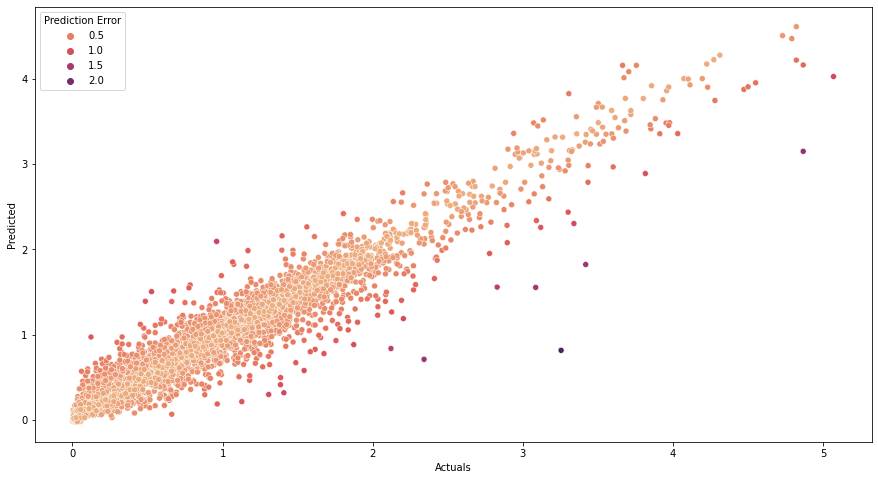

In [734]:
fig = plt.figure(figsize=(15,8))
new_difs = difs.loc[difs['Prediction Error'] != difs['Prediction Error'].max()]
_ = sns.scatterplot(x = new_difs['Actuals'], y = new_difs['Predicted'],
                hue = new_difs['Prediction Error'], palette='flare')
#fig.savefig('pred_vis.png')

The distribution plot (histogram) helps better understand the prediction error.

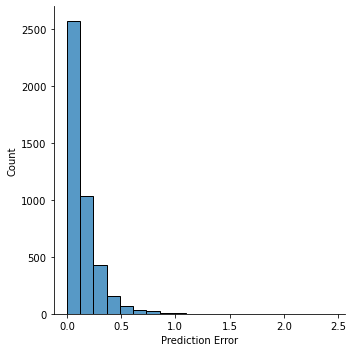

In [735]:
sns.displot(new_difs['Prediction Error'], bins=20)

# Training Other Regression Algorithms

The results above show that the linear regression is not the best predictor of the consumption, in contrast to the XGBoost algorithm, which does a great job. Now, it is worth looking into some other algorithms that are used for regression problems.

### SKLearn Linear Regression

In [736]:
from sklearn.linear_model import LinearRegression
skllnrgr = LinearRegression().fit(X_nonan, y_nonan)

preds_skllnrgr = skllnrgr.predict(X_nonan)

scores = scores.append({'Algorithm':'SKLearn Linear Regression', 'R2': metrics.r2_score(y_nonan, preds_skllnrgr),
                        'MSE': metrics.mean_squared_error(y_nonan, preds_skllnrgr)}, ignore_index=True)

print(metrics.r2_score(y_nonan, preds_skllnrgr))
print(metrics.mean_squared_error(y_nonan, preds_skllnrgr))

0.6330364497322603
0.15740731077020714


### Stochastic Gradient Descent

In [737]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sgdregr = make_pipeline(StandardScaler(),
SGDRegressor(max_iter=1000, tol=1e-3))
sgdregr.fit(X_train_nonan, y_train_nonan)
preds_sgd = sgdregr.predict(X_test_nonan)

scores = scores.append({'Algorithm':'SGD', 'R2': metrics.r2_score(y_test_nonan, preds_sgd),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_sgd)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_sgd))
print(metrics.mean_absolute_error(y_test_nonan, preds_sgd))

0.6351680691313046
0.2877602298393085


### Random Forest

In [738]:
from sklearn.ensemble import RandomForestRegressor
rfrregr = RandomForestRegressor(max_depth=30, n_jobs=-1)
rfrregr.fit(X_train_nonan, y_train_nonan)
preds_rfr = rfrregr.predict(X_test_nonan)

scores = scores.append({'Algorithm':'Random Forest', 'R2': metrics.r2_score(y_test_nonan, preds_rfr),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_rfr)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_rfr))
print(metrics.mean_absolute_error(y_test_nonan, preds_rfr))

0.907982152466177
0.11262595780725715


### Support Vector Machines

In [739]:
from sklearn import svm
svrrgr = svm.SVR()
svrrgr.fit(X_train_nonan, y_train_nonan)
preds_svm = svrrgr.predict(X_test_nonan)

scores = scores.append({'Algorithm':'SVM', 'R2': metrics.r2_score(y_test_nonan, preds_svm),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_svm)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_svm))
print(metrics.mean_absolute_error(y_test_nonan, preds_svm))

0.474043579739007
0.2975131005508705


### Ada Boost

In [740]:
from sklearn.ensemble import AdaBoostRegressor
adargr = AdaBoostRegressor(n_estimators=200)
adargr.fit(X_train_nonan, y_train_nonan)
preds_adaboost = adargr.predict(X_test_nonan)

scores = scores.append({'Algorithm':'Ada Boost', 'R2': metrics.r2_score(y_test_nonan, preds_adaboost),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_adaboost)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_adaboost))
print(metrics.mean_absolute_error(y_test_nonan, preds_adaboost))

0.43245210008352175
0.43152316241594824


### Gradient Boosting

In [741]:
from sklearn.ensemble import GradientBoostingRegressor
gdbreg = GradientBoostingRegressor(n_estimators=300, max_depth=7)
gdbreg.fit(X_train_nonan, y_train_nonan)
preds_gradboost = gdbreg.predict(X_test_nonan)

scores = scores.append({'Algorithm':'Gradient Boosting', 'R2': metrics.r2_score(y_test_nonan, preds_gradboost),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_gradboost)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_gradboost))
print(metrics.mean_absolute_error(y_test_nonan, preds_gradboost))

0.9115086371961909
0.1177120317490732


### Decision Tree

In [742]:
from sklearn.tree import DecisionTreeRegressor

tree_rgr = DecisionTreeRegressor(criterion='mae', max_depth=20)
tree_rgr.fit(X_train_nonan, y_train_nonan)
preds_dt = tree_rgr.predict(X_test_nonan)

scores = scores.append({'Algorithm':'Decision Tree', 'R2': metrics.r2_score(y_test_nonan, preds_dt),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_dt)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_dt))
print(metrics.mean_absolute_error(y_test_nonan, preds_dt))

0.8360580814718199
0.14346660503394215


### Voting Regressor (Ensemble)

In [743]:
from sklearn.ensemble import VotingRegressor
ereg = VotingRegressor(estimators=[('gb', gdbreg), ('rf', rfrregr), ('xgb', gs_xgb)])
ereg = ereg.fit(X_train_nonan, y_train_nonan)
preds_ens = ereg.predict(X_test_nonan)

scores = scores.append({'Algorithm':'Ensemble Voting Regressor', 'R2': metrics.r2_score(y_test_nonan, preds_ens),
                        'MSE': metrics.mean_squared_error(y_test_nonan, preds_ens)}, ignore_index=True)

print(metrics.r2_score(y_test_nonan, preds_ens))
print(metrics.mean_absolute_error(y_test_nonan, preds_ens))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
0.9144491260170176
0.11692942446984868


C:\Users\Nick\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [744]:
scores.set_index('Algorithm', drop=True).sort_values(by=['R2'], ascending=False)

,R2,MSE
Algorithm,,
XGBoost Grid Search,0.916843,0.046030
Ensemble Voting Regressor,0.914449,0.037600
Gradient Boosting,0.911509,0.038892
Random Forest,0.907982,0.040442
XGBoost,0.904712,0.052746
Decision Tree,0.836058,0.072053
LinRegr Best Model,0.644025,0.428976
SGD,0.635168,0.160344
SKLearn Linear Regression,0.633036,0.157407


# Decision Tree Visualisation
To better understand what goes on behind the scenes of the predictions (instead of treating the models as black boxes), the decision tree will be visualised below. It seems that the main predictory feature are the working hours, followed by the deadweight.

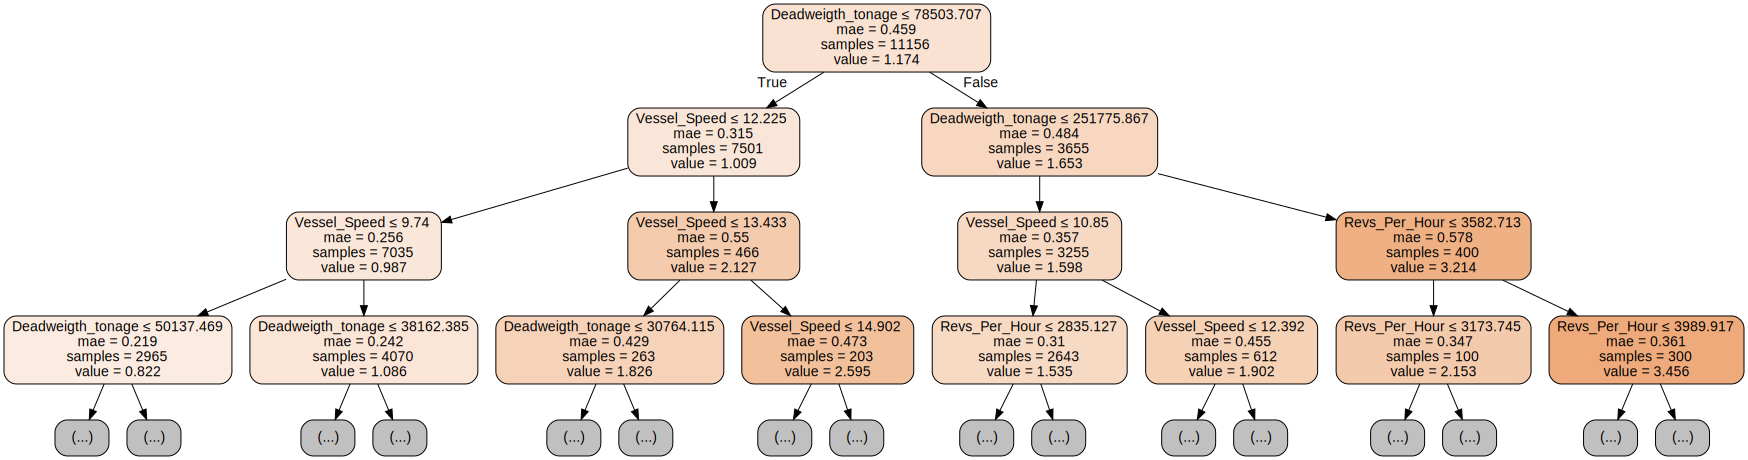

In [747]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(tree_rgr, feature_names=X_train.columns,
                      filled=True, rounded=True, max_depth=3, special_characters=True)

graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render("tree")
graph

# Above and Below Expected
Treating the predictions of the algorithm as "normal", expected values, it is worth investigating what makes certain records have more (or less) than expected fuel consumption.

In [748]:
str_len_data_h = str(len(data_h_nonan))

def pre2categ(X_values, actual):
    global i
    pred = gdbreg.predict(X_values)
    if i % 500 == 0:
        print('Predicted ' + str(i) + '/ ' + str_len_data_h)
    i += 1
    if pred < (actual*0.95):
        return 'Below Expected'
    elif (actual*1.05) < pred:
        return 'Above Expected'
    else:
        return 'Expected'

In [749]:
i = 0
data_h_nonan.loc[:, ['ConsExp']] = data_h_nonan.apply(lambda row: pre2categ([row.iloc[6:10]], row.iloc[10]), axis=1)

Predicted 0/ 13946
Predicted 500/ 13946
Predicted 1000/ 13946
Predicted 1500/ 13946
Predicted 2000/ 13946
Predicted 2500/ 13946
Predicted 3000/ 13946
Predicted 3500/ 13946
Predicted 4000/ 13946
Predicted 4500/ 13946
Predicted 5000/ 13946
Predicted 5500/ 13946
Predicted 6000/ 13946
Predicted 6500/ 13946
Predicted 7000/ 13946
Predicted 7500/ 13946
Predicted 8000/ 13946
Predicted 8500/ 13946
Predicted 9000/ 13946
Predicted 9500/ 13946
Predicted 10000/ 13946
Predicted 10500/ 13946
Predicted 11000/ 13946
Predicted 11500/ 13946
Predicted 12000/ 13946
Predicted 12500/ 13946
Predicted 13000/ 13946
Predicted 13500/ 13946


C:\Users\Nick\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The distribution of the three classes is shown below, with the expected being 56% of the data, the below expected being 19% and the above expected being slightly higher, at 26%.

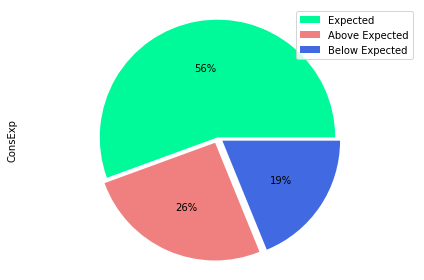

In [750]:
labels = ['Expected', 'Above Expected', 'Below Expected']

colors = ['mediumspringgreen','lightcoral','royalblue']
data_h_nonan.ConsExp.value_counts().plot.pie(explode=(0,0.05,0.05),
                                             autopct="%1.f%%", colors=colors, labels=['','','',''])
plt.legend(labels, loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()


The comparison between the three classes, concerning the consumpion, deadweight, and vessel position are found below.
1. It seems that the records with lower consumption have an even lower consumption than predicted
2. The vessels with a lower deadweight have both higher and lower values than predicted
3. The vessels with a higher latitude are consuming more than expected
4. The vessels with a higher longtitude consume less than expected, in contrast with the vessels with a lower altitude, that consume more than expected

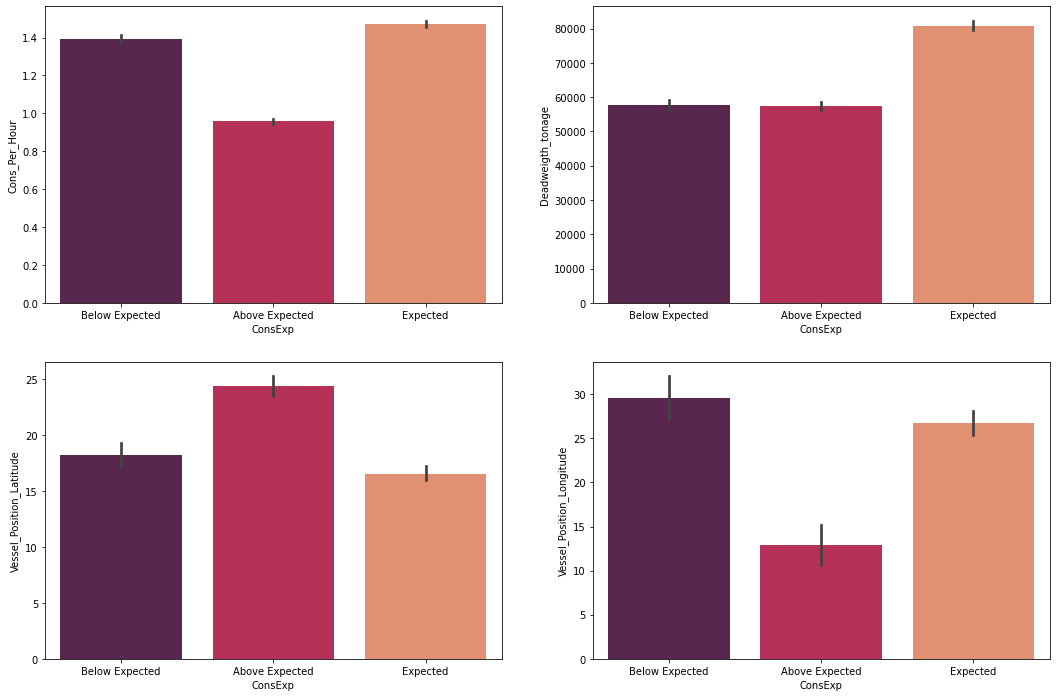

In [751]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(221)
sns.barplot(x = 'ConsExp', y='Cons_Per_Hour', data=data_h_nonan, palette='rocket', ax=ax)

ax2 = fig.add_subplot(222)
sns.barplot(x = 'ConsExp', y='Deadweigth_tonage', data=data_h_nonan, palette='rocket', ax=ax2)

ax3 = fig.add_subplot(223)
sns.barplot(x = 'ConsExp', y='Vessel_Position_Latitude', data=data_h_nonan, palette='rocket', ax=ax3)

ax4 = fig.add_subplot(224)
sns.barplot(x = 'ConsExp', y='Vessel_Position_Longitude', data=data_h_nonan, palette='rocket', ax=ax4)

plt.show()